# |This notebook only shows basic usage of ICA methods in MNE library

In [1]:
import mne
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from .. import data_processing as dp

In [2]:
import os

dir_path = './dane'

file_paths = dp.get_fire_paths(dir_path)
print(file_paths)


['./dane/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif', './dane/EEG_ExperimentBlock.HONEST_RESPONSE_TO_FAKE_IDENTITY_raw.fif', './dane/EEG_ExperimentBlock.HONEST_RESPONSE_TO_TRUE_IDENTITY_raw.fif', './dane/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_TRUE_IDENTITY_raw.fif']


In [44]:
example_file = file_paths[0]
raw = mne.io.read_raw_fif(example_file, preload=True)
raw.filter(1., 40., fir_design='firwin')

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,"16 EEG, 3 misc, 1 Stimulus, 1 System status channel information (Triux systems)"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [45]:
raw.apply_function(fun=lambda x: x * 10**-6)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,"16 EEG, 3 misc, 1 Stimulus, 1 System status channel information (Triux systems)"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [46]:
raw.pick_types(meg=False, eeg=True, eog=False, stim=False)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [60]:
raw.plot()

In [48]:
ica = ICA(n_components=len(raw.ch_names), random_state=97, max_iter='auto')
ica.fit(raw)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,16 iterations on raw data (45000 samples)
ICA components,16
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


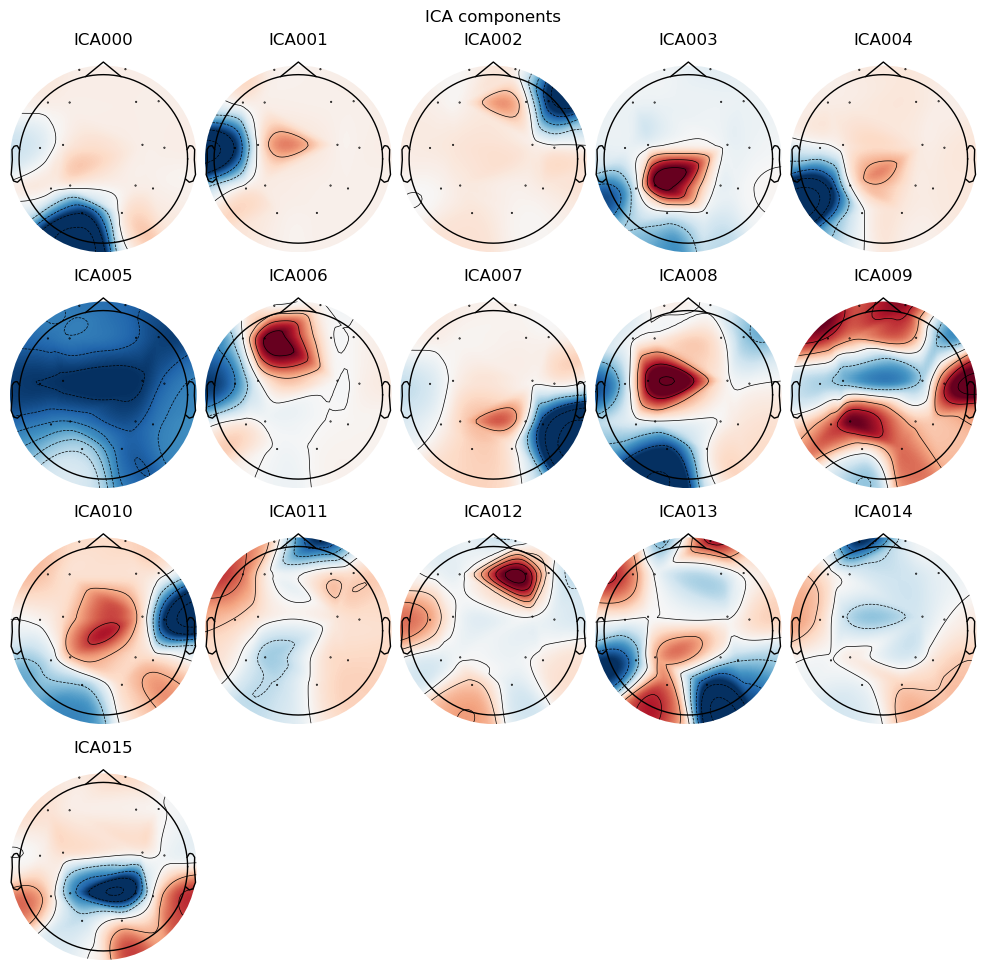

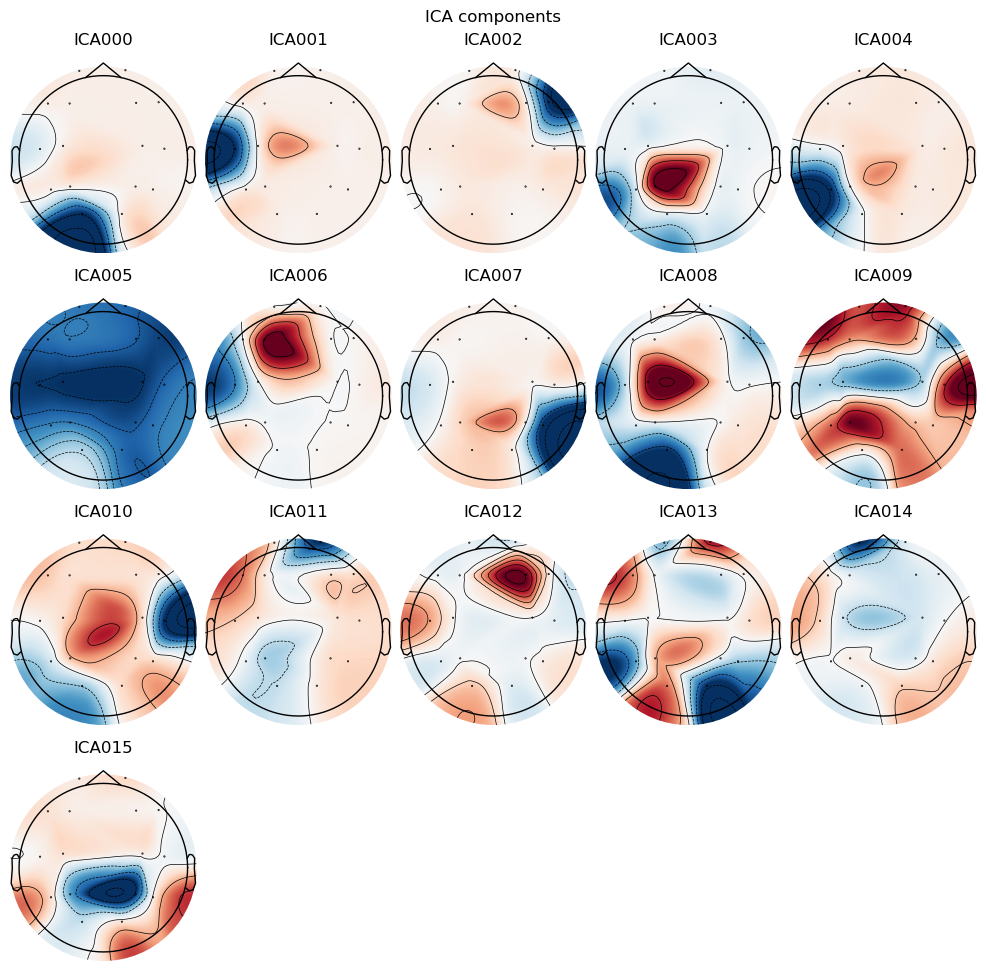

In [49]:
ica.plot_components()

In [50]:
ica.plot_sources(raw)

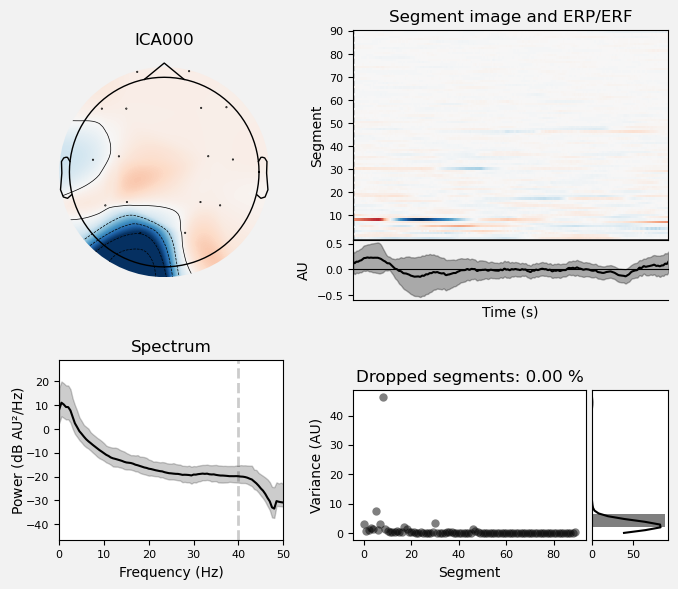

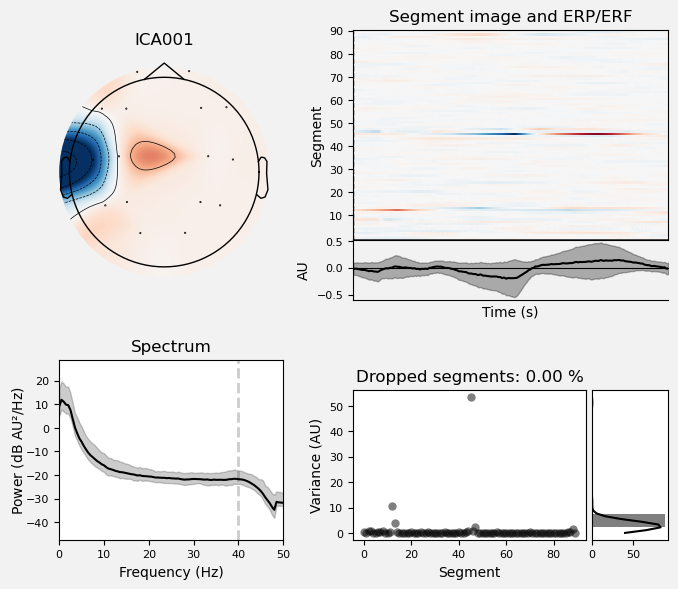

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [51]:
bad_inds = [0, 1]

ica.plot_properties(raw, picks=bad_inds)

In [52]:
# Exclude the bad components and apply the ICA solution to the raw data
# ica.exclude = bad_inds
ica.apply(raw)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [53]:
ica.exclude = bad_inds
ica.apply(raw)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [54]:
raw.plot()

In [61]:
ica.save('ica_solution.fif', overwrite=True)
raw.save('cleaned_raw.fif', overwrite=True)

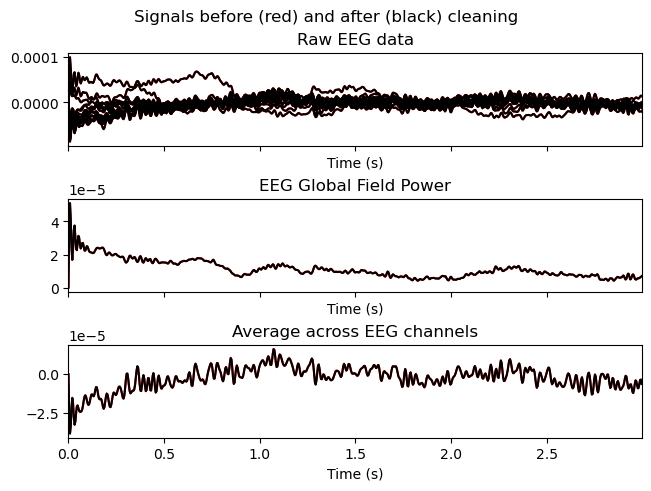

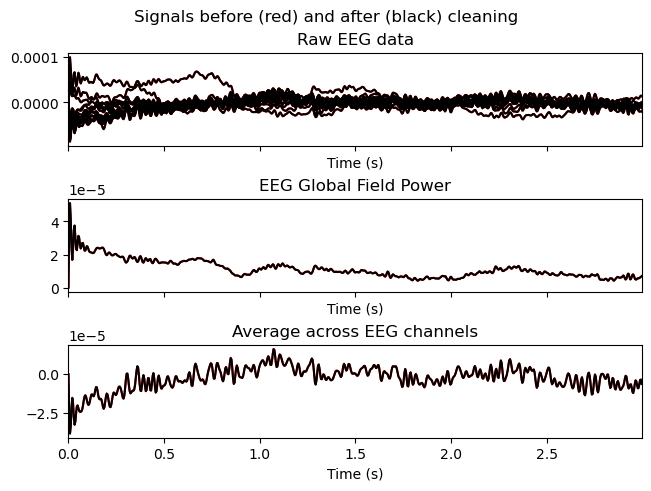

In [56]:
ica.plot_overlay(raw)

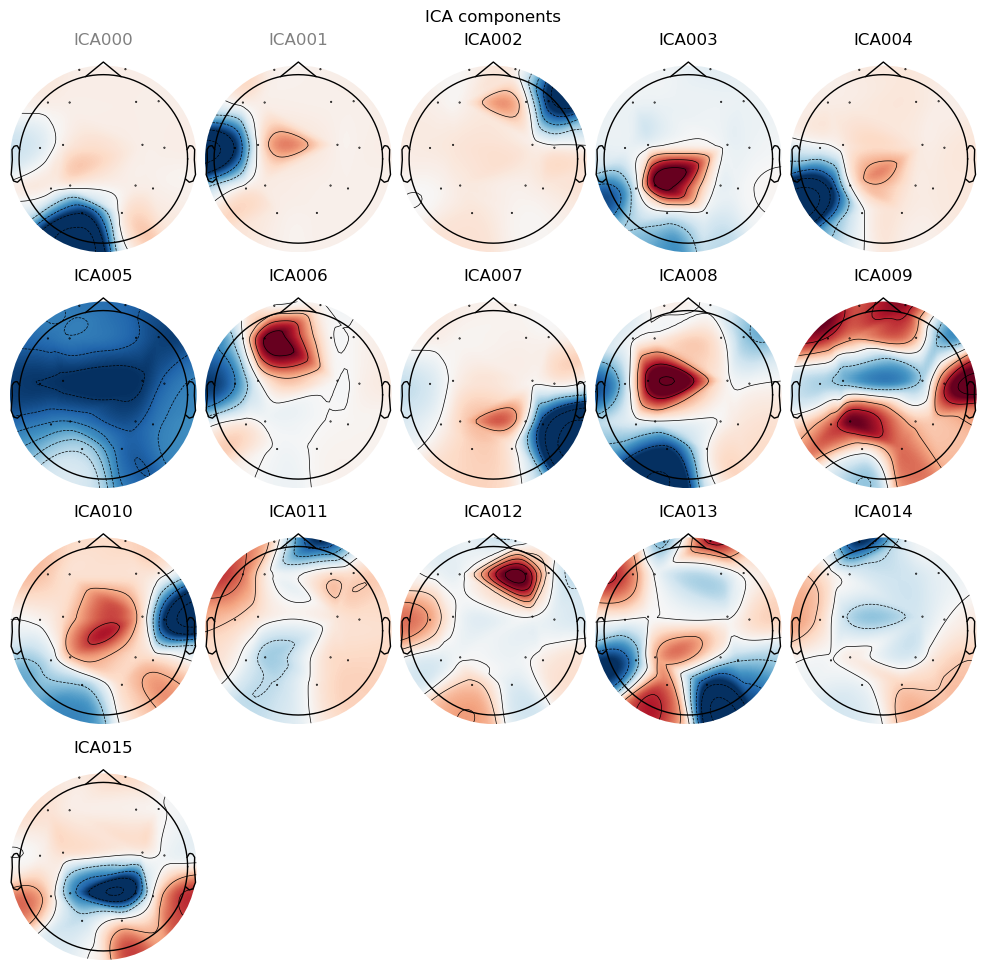

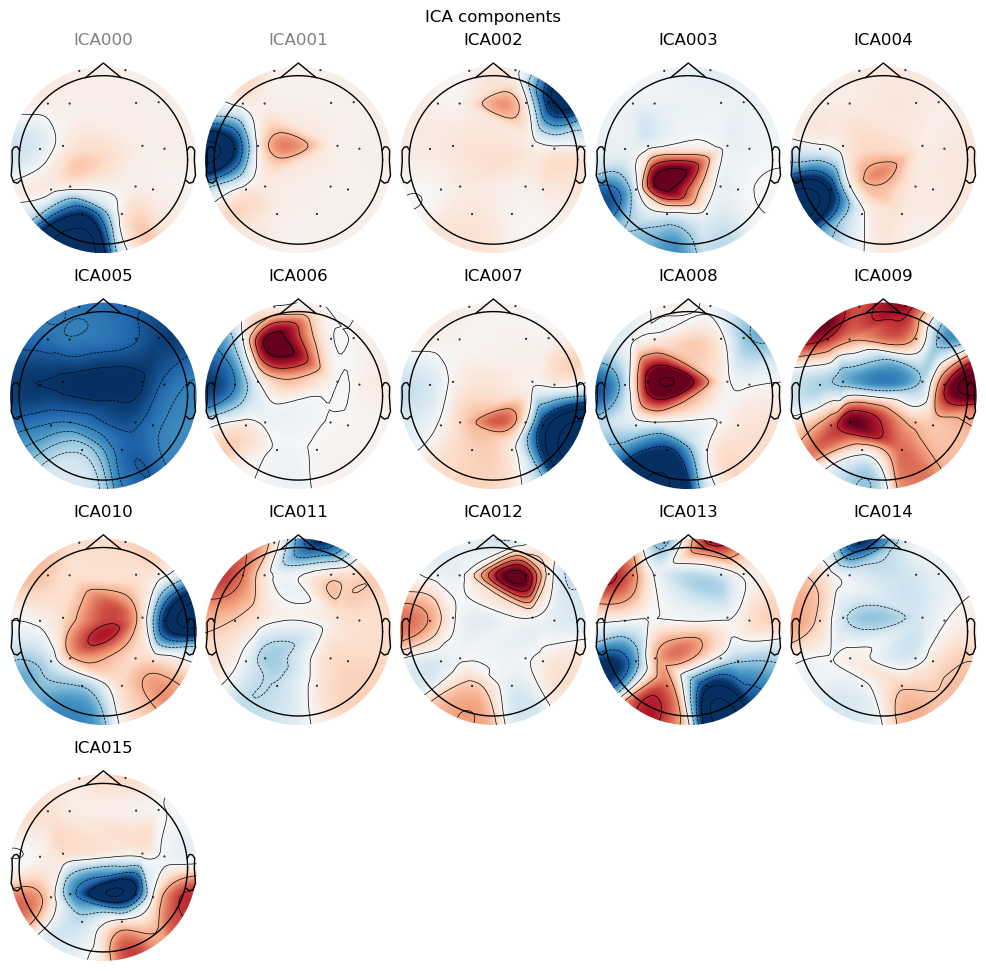

In [57]:
ica.plot_components(inst=raw, ch_type='eeg')

In [58]:
import pandas as pd

ica_sources = ica.get_sources(raw).get_data()

# Create a DataFrame from ICA component activations
ica_df = pd.DataFrame(ica_sources.T, columns=[f'ICA_{i}' for i in range(ica_sources.shape[0])])

In [66]:
raw_ica = ica.apply(raw.copy()) 

In [67]:
events, event_dict = mne.events_from_annotations(raw_ica)

epochs = mne.Epochs(raw_ica, events, event_dict, tmin=-0.2, tmax=0.5, baseline=(None, 0), preload=True)